# Class Imbalance Experiments

This notebook was used for experiments regarding our attempt to handle class imbalance via oversampling and SMOTE.

# Imports

In [ ]:
!pip install seaborn
!pip install imblearn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Data Loading

In [3]:
data_folder = '../data/processed/'
train_df = pd.read_csv(data_folder+'train_data_processed.csv')
train_df

,id,title,genre,description,year,language,processed_description_string
0,1,Oscar et la dame rose,drama,Listening in to a conversation between his do...,2009,English,listen convers doctor parent 10-year-old oscar...
1,2,Cupid,thriller,A brother and sister with a past incestuous r...,1997,English,brother sister past incestu relationship curre...
2,3,"Young, Wild and Wonderful",adult,As the bus empties the students for their fie...,1980,English,bu empti student field trip museum natur histo...
3,4,The Secret Sin,drama,To help their unemployed father make ends mee...,1915,English,help unemploy father make end meet edith twin ...
4,5,The Unrecovered,drama,The film's title refers not only to the un-re...,2007,English,film titl refer un-recov bodi ground zero also...
...,...,...,...,...,...,...,...
48785,54210,"""Bonino""",comedy,This short-lived NBC live sitcom centered on ...,1953,English,short-liv nbc live sitcom center bonino world-...
48786,54211,Dead Girls Don't Cry,horror,The NEXT Generation of EXPLOITATION. The sist...,????,English,next gener exploit sister kapa - bay soror hou...
48787,54212,Ronald Goedemondt: Ze bestaan echt,documentary,"Ze bestaan echt, is a stand-up comedy about g...",2008,English,ze bestaan echt stand-up comedi grow face fear...
48788,54213,Make Your Own Bed,comedy,Walter and Vivian live in the country and hav...,1944,English,walter vivian live countri difficult time keep...


In [4]:
train_df = train_df[train_df['language']=='English']

<AxesSubplot:xlabel='count', ylabel='genre'>

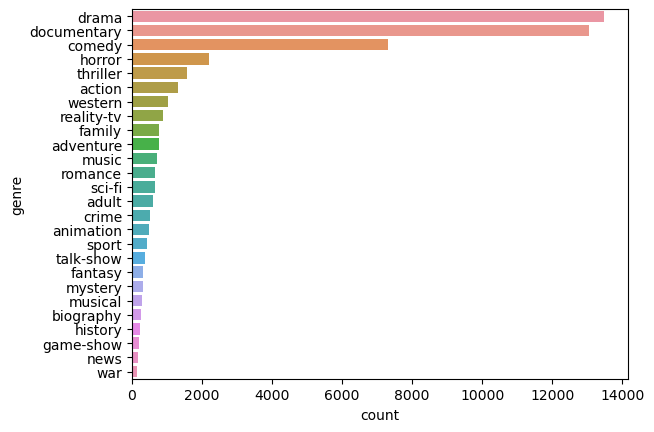

In [5]:
sns.countplot(data=train_df, y='genre',order=train_df['genre'].value_counts().index)

# Dealing with Data Imbalance with Oversampling

In [6]:
from imblearn.over_sampling import RandomOverSampler

In [7]:
X, y = train_df['processed_description_string'],train_df['genre']

<AxesSubplot:xlabel='count', ylabel='genre'>

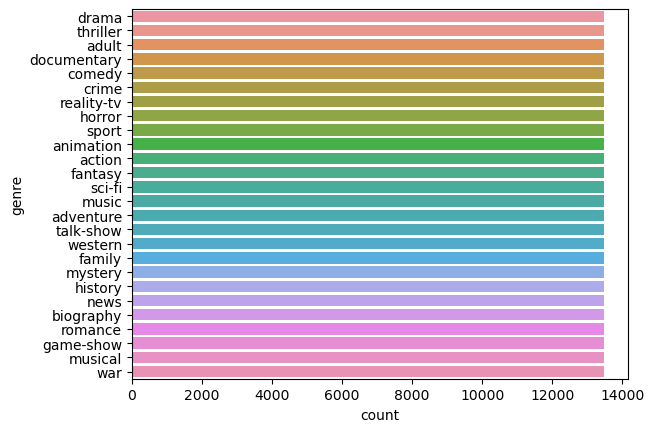

In [8]:
oversample = RandomOverSampler(sampling_strategy='not majority')
# fit and apply the transform
X_over, y_over = oversample.fit_resample(X.values.reshape(-1,1), y)
# summarize class distribution
sns.countplot(y=y_over)

In [9]:
oversampled_df = pd.DataFrame({'description':X_over.reshape(-1),'genre':y_over})
oversampled_df.head()

,description,genre
0,listen convers doctor parent 10-year-old oscar...,drama
1,brother sister past incestu relationship curre...,thriller
2,bu empti student field trip museum natur histo...,adult
3,help unemploy father make end meet edith twin ...,drama
4,film titl refer un-recov bodi ground zero also...,drama


In [10]:
data_folder

'../data/processed/'

In [ ]:
oversampled_df.to_csv(data_folder+'/oversampled/RandomOverSampled.csv')

### TFIDF and Logistic Regression

In [12]:
## TFIDF Vectorizer & Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
##model
model = LogisticRegression()

##transform text
text_transformer = TfidfVectorizer(max_features=150000)
transformed_text = text_transformer.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    transformed_text, y, test_size=0.2, random_state=42)

# cross_val_score(model, transformed_text,y,cv=5)
model.fit(X_train,y_train)
preds = model.predict(X_test)
accuracy_score(y_test,preds)

/Users/kushal/opt/anaconda3/envs/jupyter_lab/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6258454601352736

In [13]:
transformed_text.shape

(48790, 88315)

In [14]:
##transform oversampled text

text_transformer = TfidfVectorizer(max_features=150000,lowercase=False)
transformed_text = text_transformer.fit_transform(X_over.reshape(-1))
X_train, X_test_discard, y_train, y_test_discard = train_test_split(
    transformed_text, y_over, test_size=0.2, random_state=42)
# cross_val_score(model, transformed_text,y_over,cv=5)
model.fit(X_train,y_train)
preds = model.predict(X_test)
accuracy_score(y_test,preds)

/Users/kushal/opt/anaconda3/envs/jupyter_lab/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7952449272391884

# Dealing with Data Imbalance using SMOTE

In [15]:
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
## pass in number of dimensions to reduce to this function to perform dimension reduction
def do_smote(X,y,dim_red = None):
    if dim_red != None:
        pca = PCA(n_components = dim_red)
        X = pca.fit_transform(X.toarray())
    smote = SMOTE()
    X_smote, y_smote = smote.fit_resample(X, y)
    return X_smote,y_smote
    

In [16]:
type(transformed_text)

scipy.sparse._csr.csr_matrix

In [ ]:
##transform text
text_transformer = TfidfVectorizer(max_features=150000)
transformed_text = text_transformer.fit_transform(X)
X_smote,y_smote = do_smote(transformed_text,y,300)
X_train, X_test_discard, y_train, y_test_discard = train_test_split(
    X_smote, y_smote, test_size=0.2, random_state=42)
# cross_val_score(model, transformed_text,y_over,cv=5)
model.fit(X_train,y_train)
preds = model.predict(X_test)
accuracy_score(y_test,preds)